In [3]:
!pip install torch --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Game.py

In [ ]:
#game.py
import numpy as np
class dots_and_boxes():
  def __init__(self, n):
    self.n = n
    """
    Initialize the 5 layers that represent a game state
    board_tensor: shape (n, n, 5) with 4 edges per box and an extra channel for player ownership
                  channels are in [top, bottom, left, right, player owner]
    boxes_playerA: list of boxes owned by player A in (x,y)
    boxes_playerB: list of boxes owned by player B
    recent_edge: most recent edge drawn
    """
    self.board_tensor = np.zeros((n, n, 5), dtype=int)
    self.boxes_playerA = []
    self.boxes_playerB = []
    self.recent_edge = None
    self.On_Offensive = False
    self.overlapping_edges = set()
    self.non_overlapping_edges = set()
    self.initialize_edge_sets()


  def set_edge(self, r, c, edge_type):
    """
    Set the edge of box (r,c)
    edge_type: "top", "bottom", "left", "right"
    Automatically updates neighboring box if shared
    Updates recent_edge
    """
    n = self.n
    self.recent_edge = [r,c,edge_type]

    if edge_type == "top":
        self.board_tensor[r, c, 0] = 1
        if r > 0:
            self.board_tensor[r-1, c, 1] = 1  # bottom of box above
    elif edge_type == "bottom":
        self.board_tensor[r, c, 1] = 1
        if r < n-1:
            self.board_tensor[r+1, c, 0] = 1  # top of box below
    elif edge_type == "left":
        self.board_tensor[r, c, 2] = 1
        if c > 0:
          self.board_tensor[r, c-1, 3] = 1  # right of box to the left
    elif edge_type == "right":
        self.board_tensor[r, c, 3] = 1
        if c < n-1:
          self.board_tensor[r, c+1, 2] = 1  # left of box to the right

  def check_edge(self, r, c, edge_type):
    """
    Check if edge of box (r,c) is drawn
    edge_type: "top", "bottom", "left", "right"
    Returns true if available, false if not
    """
    edge_index = {"top": 0, "bottom": 1, "left": 2, "right": 3}
    if edge_type not in edge_index:
      return False
    return self.board_tensor[r, c, edge_index[edge_type]] == 0

  def check_box(self, r, c, edge_type, player):
    """
    Checks if all edges of box (r,c) are drawn
    If a box is created, assigns ownership
    Also checks if additonal box next to (r,c) is completed
    edge_type: "top", "bottom", "left", "right"
    player: 1,2
    Automatically updates boxes_playerA and boxes_playerB
    Automatically updates On_Offensive
    """
    n = self.n
    current_box = False

    if np.all(self.board_tensor[r, c, :4] == 1):
      current_box = True

      # Updating boxes_playerA or boxes_playerB
      self.board_tensor[r,c,4] = player # assigns ownership
      if player == 1:
        self.boxes_playerA.append((r,c))
      else:
        self.boxes_playerB.append((r,c))

    additional_box = False

    # Used to update the boxes under each player with the appropriate additional box
    additional_r = r
    additional_c = c

    if edge_type == "top":
      if r > 0:  # check box above
        if np.all(self.board_tensor[r-1, c, :4] == 1): # all edges are filled in
          additional_box = True
          self.board_tensor[r-1, c, 4] = player # assigns ownership
          additional_r = r-1

    elif edge_type == "bottom":
      if r < (n-1):  # check box below
        if np.all(self.board_tensor[r+1, c, :4] == 1): # all edges are filled in
          additional_box = True
          self.board_tensor [r+1, c, 4] = player # assigns ownership
          additional_r = r+1

    elif edge_type == "left":
      if c > 0: # check the box to the left
        if np.all(self.board_tensor[r,c-1, :4] == 1):
          additional_box = True
          self.board_tensor[r, c-1, 4] = player # assigns ownership
          additional_c = c-1

    elif edge_type == "right":
      if c < (n-1): # check the box to the right
        if np.all(self.board_tensor[r, c+1, :4] == 1):
          additional_box = True
          self.board_tensor [r, c+1, 4] = player # assigns ownership
          additional_c = c+1

    # Updating boxes_playerA or boxes_playerB
    if additional_box:
      if player == 1:
        self.boxes_playerA.append((additional_r,additional_c))
      else:
        self.boxes_playerB.append((additional_r,additional_c))

    # Updating On_Offensive
    self.On_Offensive = current_box or additional_box

    return int(current_box) + int(additional_box)


  def print_board_ascii(self, move, player, initial = False):
    """
    Print the current board
    move: move number
    player: player number
    initial: True if first time showing the board
    """
    n = self.n
    board_tensor = self.board_tensor
    BOX_WIDTH = 7

    if(initial):
      print()
      intro = "Welcome!"
      intro = intro.center(BOX_WIDTH * n + 5)
      print(intro)
      welcome = "Here is the board"
      welcome = welcome.center(BOX_WIDTH * n + 5)
      print(welcome)
    else:
      player_intro = f"Player {player} , Move {move}"
      player_intro = player_intro.center(BOX_WIDTH * n + 5)
      print(player_intro)
    for r in range(n):
        # Print top edges
        top_row = " "
        for c in range(n):
            top_row += "+" #prints all points
            top_row += "-" * BOX_WIDTH if board_tensor[r, c, 0] else " " * BOX_WIDTH # prints a horizontal line the same length as box width
        top_row += "+"
        print(top_row)

        # Print vertical edges and ownership/coordinates
        mid_row = " "
        for c in range(n):
            mid_row += "|" if board_tensor[r, c, 2] else " "

            # show coordinates unless box is owned (shows owner in that case)
            owner = board_tensor[r, c, 4]
            content = str(int(owner)) if owner else f"({r},{c})"
            content = content.center(BOX_WIDTH)
            mid_row += content

        # last right edge of the row
        mid_row += "|" if board_tensor[r, n-1, 3] else " "
        print(mid_row)

    # Print bottom edges of last row
    bottom_row = " "
    for c in range(n):
        bottom_row += "+"
        bottom_row += "-" * BOX_WIDTH if board_tensor[n-1, c, 1] else " " * BOX_WIDTH # prints a horizontal line the same length as box width
    bottom_row += "+"
    print(bottom_row)
    print()

  def player_turn(self, r, c, edge_type, player,  move):
  # Essentially just instantiates other functions that are used in a turn
    self.set_edge(r, c, edge_type)
    completed_box = self.check_box(r, c, edge_type, player) # if want to find out how many boxes made by a move
    self.print_board_ascii(move, player)
    return completed_box

  def initialize_edge_sets(self):
    """
    Initalizes both edge set types (overlapping and nonoverlapping)
    with the appropriate edge tuples based on n
    """
    n = self.n

    #initialize non-overlapping
    for r in range(n):
        for c in range(n):
            # top boundary
            if r == 0:
                self.non_overlapping_edges.add((r, c, "top"))
            # bottom boundary
            if r == n - 1:
                self.non_overlapping_edges.add((r, c, "bottom"))
            # left boundary
            if c == 0:
                self.non_overlapping_edges.add((r, c, "left"))
            # right boundary
            if c == n - 1:
                self.non_overlapping_edges.add((r, c, "right"))
    #initalize overlapping
    for r in range(n):
          for c in range(n):
              # top overlaps with box above
              if r > 0:
                  self.overlapping_edges.add((r, c, "top"))
              # bottom overlaps with box below
              if r < n - 1:
                  self.overlapping_edges.add((r, c, "bottom"))
              # left overlaps with box to the left
              if c > 0:
                  self.overlapping_edges.add((r, c, "left"))
              # right overlaps with box to the right
              if c < n - 1:
                  self.overlapping_edges.add((r, c, "right"))



In [ ]:
# @title

# OLD CODE TESTING INITIALIZATION AND SETTING EDGE AND CHECKING IF BOXES COMPLETE AND DRAWING THEM
# Initialize 2x2 board
# board = init_box_tensor(2)

# completed_boxes_player1 = 0
# completed_boxes_player2 = 0

# # Draw the top edge of box (0,0)
# set_edge(board, 0, 0, "top")
# completed_boxes_player1 += check_box(board, 0, 0, "top", 1)
# print_board_ascii(board, 1, 1)

# # Draw the left edge of box (0,0)
# set_edge(board, 0, 0, "left")
# completed_boxes_player2 += check_box(board, 0, 0, "left", 2)
# print_board_ascii(board, 2, 2)

# # Draw the bottom edge of box (0,0)
# set_edge(board, 0, 0, "bottom")
# completed_boxes_player1 += check_box(board, 0, 0, "bottom", 1)
# print_board_ascii(board, 3, 1)

# # Draw the top edge of box (0,1)
# set_edge(board, 0, 1, "top")
# completed_boxes_player2 += check_box(board, 0, 1, "top", 2)
# print_board_ascii(board, 4, 2)

# # Draw the right edge of box (0,1)
# set_edge(board, 0, 1, "right")
# completed_boxes_player1 += check_box(board, 0, 1, "right", 1)
# print_board_ascii(board, 5, 1)

# # Draw the bottom edge of box (0,1)
# set_edge(board, 0, 1, "bottom")
# completed_boxes_player2 += check_box(board, 0, 1, "bottom", 2)
# print_board_ascii(board, 6, 2)

# # Draw the left edge of box (0,1) => completes 2 boxes for player 1
# set_edge(board, 0, 1, "left")
# completed_boxes_player1 += check_box(board, 0, 1, "left", 1)
# print_board_ascii(board, 7, 1)

# print(board[0,0])  # Should be [1,1,1,1] => all edges drawn
# print("player 1 has", completed_boxes_player1, "boxes") # Should be 2
# print("player 2 has", completed_boxes_player2, "boxes") # Should be 0


---
# Gameplay Loop

In [6]:
def gameplay():
# Initializing board and vars
  n = int(input("Enter board size to start: "))
  game = dots_and_boxes(n)
  move = 1
  player = 1
  game.print_board_ascii(move, player, initial = True)

# Players take turns until all boxes made
  while (len(game.boxes_playerA) + len(game.boxes_playerB)) < n**2:
    if(game.On_Offensive):
      print(f"Player {player}'s turn again!\n")
    else:
      print(f"Player {player}'s turn!")

    valid_move = False
    while not valid_move:
      try:
        # Getting parameters for edge to draw
        s = input("Enter the box to place edge as (row,column): ")
        s = s.strip()
        s = s.strip("(").strip(")")
        r,c = s.split(",")
        r = int(r)
        c = int(c)

        # Check if row coordinate is within bounds
        if r < 0 or r >= n:
          print(f"Invalid row coordinate! Please enter values between 0 and {n-1}.\n")
          continue

        # Check if column coordinate is within bounds
        if c < 0 or c >= n:
          print(f"Invalid column coordinate! Please enter values between 0 and {n-1}.\n")
          continue

        edge_type = input("Select what edge to place the line on from 'top', 'bottom', 'left', and 'right': ")
        print()

        # Check if edge_type is valid
        if edge_type not in ["top", "bottom", "left", "right"]:
          print("Invalid edge type! Please enter 'top', 'bottom', 'left', or 'right'.\n")
          continue

        # Check if edge is already drawn
        if not game.check_edge(r, c, edge_type):
          print("That edge is already drawn! Please choose a different edge.\n")
          continue

        # If all checks pass, the move is valid
        valid_move = True

      except ():
        continue

    # Making changes to board based on edge drawn
    _ = game.player_turn(r, c, edge_type, player, move)

    # Updating parameters for next turn
    move += 1
    if not game.On_Offensive:
      if player == 1:
        player = 2
      else:
        player = 1

  # Checking who won afer game ended
  if (len(game.boxes_playerA) > len(game.boxes_playerB)):
    print("Congratulations! Player 1 wins!")
  elif(len(game.boxes_playerB) > len(game.boxes_playerA)):
    print("Congratulations! Player 2 wins!")
  else:
    print("Woah! It's a tie!")

---
# Testing gameplay loop

In [7]:
#gameplay()

---
# Model.py


In [8]:
#model.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------------------------------
# Residual block (AlphaZero style)
# ----------------------------------------------------
class ResidualBlock(nn.Module):

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu  = nn.ReLU()

    def forward(self, x):

        residual = x

        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)

        # Add skip connection
        x = x + residual

        x = self.relu(x)

        return x



# ----------------------------------------------------
# Main Network
# ----------------------------------------------------
class Connect2Model(nn.Module):

    def __init__(self, board_size, device):

        super(Connect2Model, self).__init__()

        self.device = device
        self.size = board_size                                    # n x n boxes x 5 channels
        n = board_size[0]

        self.action_size = 2 * n * (n + 1)

        # ---------------------------------------------
        # Initial convolution
        # ---------------------------------------------
        self.conv_input = nn.Conv2d(in_channels=6, out_channels=32,
                                    kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # ---------------------------------------------
        # Residual tower (3 blocks for now)
        # ---------------------------------------------
        self.res1 = ResidualBlock(32)
        self.res2 = ResidualBlock(32)
        self.res3 = ResidualBlock(32)

        # ---------------------------------------------
        # Policy head
        # ---------------------------------------------
        self.policy_conv = nn.Conv2d(32, 2, kernel_size=1)          # 1x1 conv
        self.policy_fc   = nn.Linear(2 * n * n, self.action_size)   # flatten → action vector

        # ---------------------------------------------
        # Value head
        # ---------------------------------------------
        self.value_conv = nn.Conv2d(32, 1, kernel_size=1)           # 1x1 conv
        self.value_fc1  = nn.Linear(1 * n * n, 64)
        self.value_fc2  = nn.Linear(64, 1)

        self.to(device)



    # ----------------------------------------------------
    # Forward pass
    # ----------------------------------------------------
    def forward(self, x):

        # Initial conv
        x = self.conv_input(x)
        x = self.relu(x)

        # Residual blocks
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)

        # --------------------------
        # POLICY HEAD
        # --------------------------
        p = self.policy_conv(x)               # shape: batch × 2 × n × n
        p = p.reshape(p.size(0), -1)             # flatten
        p = self.policy_fc(p)                 # output action logits

        # --------------------------
        # VALUE HEAD
        # --------------------------
        v = self.value_conv(x)                # batch × 1 × n × n
        v = v.view(v.size(0), -1)
        v = self.value_fc1(v)
        v = torch.tanh(self.value_fc2(v))     # scalar in [-1, 1]

        return p, v


# MCTS.py (network based - using policy,priors etc)


In [9]:
import numpy as np
import torch
import torch.nn.functional as F
import math
from copy import deepcopy

# ----------------------------------------------------
# Node in the MCTS
# ----------------------------------------------------
class MCTSNode:
    def __init__(self, state, parent=None, prior_prob=0):
        self.state = state  # game state
        self.parent = parent
        self.children = {}
        self.visit_count = 0
        self.value_sum = 0
        self.prior_prob = prior_prob

    def is_expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def select_child(self, c_puct=1.4):
        """Select child with highest UCB score"""
        best_score = -float('inf')
        best_action = None
        best_child = None

        for action, child in self.children.items():
            # UCB formula: Q(s,a) + c_puct * P(s,a) * sqrt(N(s)) / (1 + N(s,a))
            q_value = child.value()
            u_value = c_puct * child.prior_prob * math.sqrt(self.visit_count) / (1 + child.visit_count)
            score = q_value + u_value

            if score > best_score:
                best_score = score
                best_action = action
                best_child = child

        return best_action, best_child

# ----------------------------------------------------
# MCTS Algorithm (using policy network to evaluate)
# ----------------------------------------------------
class MCTS:
    def __init__(self, model, device, num_simulations=100, c_puct=1.4):
        self.model = model
        self.num_simulations = num_simulations
        self.c_puct = c_puct
        self.device = device

    # ----------------------------------------------------
    # Helper functions to be used in the tree functions
    # ----------------------------------------------------

    """Function to convert the board representation to a number"""
    def decode_action(self, action, n):
        # Horizontal edges: 0 to n*(n+1)-1
        # These represent horizontal lines in the grid
        total_horizontal = n * (n + 1)

        if action < total_horizontal:
            row_idx = action // n
            col_idx = action % n

            # This horizontal edge is the top of box (row_of_edge, col_of_edge)
            # or the bottom of box (row_of_edge-1, col_of_edge)
            # We'll use it as top edge when possible
            if row_idx < n:
                return row_idx, col_idx, "top"
            else: # row_idx == n
                return n - 1, col_idx, "bottom"

        # Vertical edges: n*(n+1) to 2*n*(n+1)-1
        # These represent vertical lines in the grid
        else:
            action -= total_horizontal
            row_idx = action // (n + 1)
            col_idx = action % (n + 1)

            # This vertical edge is the left of box (row_of_edge, col_of_edge)
            # or the right of box (row_of_edge, col_of_edge-1)
            # We'll use it as left edge when possible
            if col_idx < n:
                return row_idx, col_idx, "left"
            else: # col_idx == n
                # This is the rightmost edge
                return row_idx, n - 1, "right"

    """Function to convert game state to neural network format"""
    def state_to_input(self, state, player):
        # Transpose to format that neural network expects: (5,n,n)
        board = np.transpose(state.board_tensor, (2, 0, 1)).astype(np.float32)

        # Add player perspective channels
        n = state.n
        player_channel = np.full((1,n,n), 1.0 if player == 1 else -1.0, dtype=np.float32)

        # Swap ownership channel based on player perspective
        ownership = board[4:5].copy()
        if player == 2:
            # From P2's perspective, swap the ownership encoding
            ownership_swapped = np.zeros_like(ownership)
            ownership_swapped[ownership == 1] = 2
            ownership_swapped[ownership == 2] = 1
            ownership_swapped[ownership == 0] = 0
            board = board.copy()
            board[4:5] = ownership_swapped

        board_with_player = np.concatenate([board, player_channel], axis=0)

        return board_with_player

    """Function to get binary mask of valid actions"""
    def get_valid_actions(self, state):
        n = state.n
        valid_actions = np.zeros(2 * n * (n + 1), dtype=np.float32)

        # Changed for all edges in the grid
        for r in range(n):
            for c in range(n):
                for edge_type in ["top", "bottom", "left", "right"]:
                    if state.check_edge(r, c, edge_type):
                        # Convert (r, c, edge_type) to action index
                        action = self.encode_action(r, c, edge_type, n)
                        if action is not None:
                            valid_actions[action] = 1

        return valid_actions
    
    """Added for encoding action"""
    def encode_action(self, r, c, edge_type, n):
        """Convert (r, c, edge_type) to action index"""
        if edge_type == "top":
            return r * n + c
        elif edge_type == "bottom":
            if r == n - 1:
                return n * n + c
            else:
                # Bottom of box (r, c) is top of box (r+1, c)
                return (r + 1) * n + c
        elif edge_type == "left":
            return n * (n + 1) + r * (n + 1) + c
        elif edge_type == "right":
            if c == n - 1:
                return n * (n + 1) + r * (n + 1) + n
            else:
                # Right of box (r, c) is left of box (r, c+1)
                return n * (n + 1) + r * (n + 1) + c + 1
        return None

    """Function to check if game is over"""
    def is_terminal(self, state):
        total_boxes = state.n ** 2
        total_filled = len(state.boxes_playerA) + len(state.boxes_playerB)
        return total_filled == total_boxes

    """Function to get value for terminal state from perspective of player"""
    def get_terminal_value(self, state, player):
        if player == 1:
            score_diff = len(state.boxes_playerA) - len(state.boxes_playerB)
        else:
            score_diff = len(state.boxes_playerB) - len(state.boxes_playerA)

        if score_diff > 0:
            return 1.0
        elif score_diff < 0:
            return -1.0
        else:
            return 0.0

    # ----------------------------------------------------
    # Tree functions
    # ----------------------------------------------------

    """Function to use the policy network to evaluate the position"""
    def evaluate(self, state, player):
        self.model.eval()
        with torch.no_grad():
            # Prepare input
            board_input = self.state_to_input(state, player)
            board_tensor = torch.FloatTensor(board_input).unsqueeze(0).to(self.device)

            # Get policy and value from network
            policy_logits, value = self.model(board_tensor)
            policy_probs = F.softmax(policy_logits, dim=1).cpu().numpy()[0]
            value = value.item()

        return policy_probs, value

    """Function to backpropagate the value up the tree"""
    def backpropagate(self, search_path, value, player):
        for node in reversed(search_path):
            node.value_sum += value
            node.visit_count += 1
            value = -value  # Flip value for opponent

    """Function to run MCTS simulations and return action probabilities"""
    def search(self, root_state, player, temperature=1.0):
        root = MCTSNode(deepcopy(root_state))

        for _ in range(self.num_simulations):
            node = root
            search_path = [node]
            current_state = deepcopy(root_state)
            current_player = player

            # Selection: traverse tree using UCB
            while node.is_expanded():
                action, node = node.select_child(self.c_puct)
                search_path.append(node)

                # Apply action to state
                r, c, edge_type = self.decode_action(action, current_state.n)
                current_state.set_edge(r, c, edge_type)
                boxes_made = current_state.check_box(r, c, edge_type, current_player)

                # Switch player only if no box was completed
                if boxes_made == 0:
                    current_player = 3 - current_player # Switches 1 to 2 and 2 to 1

            # Check if game is over
            if self.is_terminal(current_state):
                value = self.get_terminal_value(current_state, player)
            else:
                # Expansion and Evaluation
                policy_probs, value = self.evaluate(current_state, current_player)
                valid_actions = self.get_valid_actions(current_state)

                # Mask invalid actions
                policy_probs = policy_probs * valid_actions
                if policy_probs.sum() > 0:
                    policy_probs = policy_probs / policy_probs.sum()

                # Expand node
                for action in range(len(policy_probs)):
                    if valid_actions[action] > 0:
                        node.children[action] = MCTSNode(
                            deepcopy(current_state),
                            parent=node,
                            prior_prob=policy_probs[action]
                        )

                # Adjust value based on current player perspective
                if current_player != player:
                    value = -value

            # Backpropagation
            self.backpropagate(search_path, value, player)

        # Return action probabilities based on visit counts
        return self.get_action_probs(root, temperature)

    """Function to get the acion probabilities from the visit counts"""
    def get_action_probs(self, root, temperature=1.0):
        action_size = 2 * root.state.n * (root.state.n + 1)
        visit_counts = np.zeros(action_size, dtype=np.float32)

        for action, child in root.children.items():
            visit_counts[action] = child.visit_count

        if temperature == 0:
            # Deterministic: pick most visited
            probs = np.zeros_like(visit_counts)
            probs[np.argmax(visit_counts)] = 1.0
            return probs
        else:
            # Apply temperature
            visit_counts = visit_counts ** (1.0 / temperature)
            if visit_counts.sum() > 0:
                probs = visit_counts / visit_counts.sum()
            else:
                probs = visit_counts
            return probs


---
# execute_episode for self.play() loop to generate training data

In [10]:
import copy
import random
import time

class SelfPlay:
    def __init__(self, game, model, device, num_simulations=100, temperature=1.0):
        self.game = game
        self.model = model
        self.device = device
        self.num_simulations = num_simulations
        self.temperature = temperature

    def execute_episode(self):
        """
        Play 1 full self-play game using MCTS, essentially 2 AI's versing eachother using MCTS.
        Returns a list of (state, move, z(final game outcome)) tuples.
        """
        # Changed to store (board_tensor_5ch, pi, cur_player) before final result calculation
        temp_training_examples = []
        state = self.game  # starting board
        cur_player = 1

        mcts = MCTS(
            model=self.model,
            device=self.device,
            num_simulations=self.num_simulations
        )

        move_number = 1

        while True:
            # canonical_state is the board_tensor (5 channels)
            canonical_state = copy.deepcopy(state.board_tensor)

            # dynamic temperature
            if move_number <= 6:
                current_temp = 1.5
            else:
                current_temp = 0.5

            # Get move from MCTS
            pi = mcts.search(state, cur_player, temperature=current_temp)

            # Save example including the player whose turn it was
            temp_training_examples.append((canonical_state, pi, cur_player))

            # Apply action
            action = np.random.choice(len(pi), p=pi)
            r, c, edge_type = mcts.decode_action(action, state.n)

            state.set_edge(r, c, edge_type)
            completed_boxes = state.check_box(r, c, edge_type, cur_player)

            move_number += 1

            # Determine next player based on completed box check
            if completed_boxes == 0:
                cur_player = 3 - cur_player

            # Check for terminal state
            if mcts.is_terminal(state):
                state.print_board_ascii(move_number, cur_player)
                winner_val = mcts.get_terminal_value(state, 1)  # value for player 1

                final_data = []
                for recorded_state_5ch, recorded_pi, recorded_player_id in temp_training_examples:
                    # z is the outcome from the perspective of recorded_player_id
                    z = winner_val if recorded_player_id == 1 else -winner_val
                    # Store player_id too, it's needed for creating the 6-channel input during training
                    final_data.append((recorded_state_5ch, recorded_pi, z, recorded_player_id))
                return final_data


---
# pure_MCTS.py (implemented from ai-service.py file in GitHub)

In [11]:
#pure_MCTS.py
import numpy as np
import time
import random
import math

class pureMCTSNode:
    """Node in the MCTS tree for dots_and_boxes game"""

    def __init__(self, game_state, current_player, parent=None, move=None):
        """
        game_state: dots_and_boxes object
        current_player: The player whose turn it is to make a move from this state (1 or 2)
        move: tuple (r, c, edge_type) that led to this node
        """
        self.game_state = game_state
        self.current_player = current_player
        self.parent = parent
        self.move = move

        self.children = []
        self.untried_moves = self.get_legal_moves()

        self.visits = 0
        self.wins = 0.0

    def get_legal_moves(self):
        """Get all legal moves from current state"""
        moves = []
        n = self.game_state.n

        for r in range(n):
            for c in range(n):
                for edge_type in ["top", "bottom", "left", "right"]:
                    if self.game_state.check_edge(r, c, edge_type):
                        moves.append((r, c, edge_type))

        return moves

    def is_fully_expanded(self):
        """Check if all children have been created"""
        return len(self.untried_moves) == 0

    def is_terminal(self):
        """Check if game is over"""
        n = self.game_state.n
        total_boxes = n ** 2
        total_filled = len(self.game_state.boxes_playerA) + len(self.game_state.boxes_playerB)
        return total_filled == total_boxes

    def best_child(self, exploration_weight=1.41):
        """
        Select best child using UCB1 formula
        UCB1 = (wins / visits) + C * sqrt(ln(parent_visits) / visits)
        """
        choices_weights = []

        for child in self.children:
            if child.visits == 0:
                ucb1_score = float('inf')
            else:
                exploitation = child.wins / child.visits
                exploration = exploration_weight * math.sqrt(math.log(self.visits) / child.visits)
                ucb1_score = exploitation + exploration

            choices_weights.append(ucb1_score)

        return self.children[choices_weights.index(max(choices_weights))]

    def most_visited_child(self):
        """Return the child with the most visits"""
        return max(self.children, key=lambda c: c.visits)

    def expand(self):
        """Add a new child node for an untried move"""
        move = self.untried_moves.pop()
        new_state = self.deep_copy_state()

        # Apply the move to the copied state
        r, c, edge_type = move
        new_state.set_edge(r, c, edge_type)
        new_state.check_box(r, c, edge_type, self.current_player) # Pass current_player

        # Determine the player for the child node
        next_player_for_child = self.current_player if new_state.On_Offensive else (3 - self.current_player)

        child_node = pureMCTSNode(new_state, next_player_for_child, parent=self, move=move)
        self.children.append(child_node)
        return child_node

    def deep_copy_state(self):
        """Create a deep copy of game state"""
        n = self.game_state.n
        new_game = dots_and_boxes(n)
        new_game.board_tensor = self.game_state.board_tensor.copy()
        new_game.boxes_playerA = self.game_state.boxes_playerA.copy()
        new_game.boxes_playerB = self.game_state.boxes_playerB.copy()
        new_game.recent_edge = self.game_state.recent_edge
        new_game.On_Offensive = self.game_state.On_Offensive
        return new_game

    def simulate(self):
        """
        Simulate a game from this node until the end (ROLLOUT)
        Uses semi-intelligent policy: prioritize box-completing moves
        Returns the result from the perspective of self.current_player (1.0 for win, 0.5 for draw, 0.0 for loss)
        """
        state = self.deep_copy_state()
        sim_current_player = self.current_player

        while True:
            n = state.n
            total_boxes = n ** 2
            total_filled = len(state.boxes_playerA) + len(state.boxes_playerB)

            if total_filled == total_boxes:
                # Game over - return result from the perspective of self.current_player
                player1_final_score = len(state.boxes_playerA)
                player2_final_score = len(state.boxes_playerB)

                if player1_final_score > player2_final_score:
                    winner = 1
                elif player2_final_score > player1_final_score:
                    winner = 2
                else:
                    winner = 0 # Draw

                if self.current_player == winner:
                    return 1.0 # Node's player won the simulated game
                elif winner == 0:
                    return 0.5 # Draw
                else:
                    return 0.0 # Node's player lost the simulated game

            # Get legal moves and categorize them
            legal_moves = []
            completing_moves = []
            safe_moves = []

            for r in range(n):
                for c in range(n):
                    for edge_type in ["top", "bottom", "left", "right"]:
                        if state.check_edge(r, c, edge_type):
                            move = (r, c, edge_type)
                            legal_moves.append(move)

                            if self.move_completes_box(state, move, sim_current_player):
                                completing_moves.append(move)
                            elif not self.move_gives_box(state, move, sim_current_player):
                                safe_moves.append(move)

            if not legal_moves:
                return 0.5

            # Smart move selection
            if completing_moves and random.random() < 0.8:
                move = random.choice(completing_moves)
            elif safe_moves and random.random() < 0.6:
                move = random.choice(safe_moves)
            else:
                move = random.choice(legal_moves)

            r, c, edge_type = move
            state.set_edge(r, c, edge_type)
            _ = state.check_box(r, c, edge_type, sim_current_player)

            # Switch player if no boxes were completed
            if not state.On_Offensive:
                sim_current_player = 3 - sim_current_player

    def move_completes_box(self, state, move, player):
        """Check if a move would complete at least one box for the given player"""
        r, c, edge_type = move
        temp_state = self.deep_copy_state_from(state)
        temp_state.set_edge(r, c, edge_type)

        n = temp_state.n
        completed = 0

        if np.all(temp_state.board_tensor[r, c, :4] == 1) and temp_state.board_tensor[r, c, 4] == 0:
            completed += 1

        if edge_type == "top" and r > 0:
            if np.all(temp_state.board_tensor[r-1, c, :4] == 1) and temp_state.board_tensor[r-1, c, 4] == 0:
                completed += 1
        elif edge_type == "bottom" and r < n-1:
            if np.all(temp_state.board_tensor[r+1, c, :4] == 1) and temp_state.board_tensor[r+1, c, 4] == 0:
                completed += 1
        elif edge_type == "left" and c > 0:
            if np.all(temp_state.board_tensor[r, c-1, :4] == 1) and temp_state.board_tensor[r, c-1, 4] == 0:
                completed += 1
        elif edge_type == "right" and c < n-1:
            if np.all(temp_state.board_tensor[r, c+1, :4] == 1) and temp_state.board_tensor[r, c+1, 4] == 0:
                completed += 1

        return completed > 0

    def move_gives_box(self, state, move, player):
        """Check if a move creates a box with 3 sides (giving opponent an opportunity)"""
        r, c, edge_type = move
        temp_state = self.deep_copy_state_from(state)
        temp_state.set_edge(r, c, edge_type)

        n = temp_state.n

        for box_r in range(n):
            for box_c in range(n):
                if temp_state.board_tensor[box_r, box_c, 4] == 0:
                    sides = np.sum(temp_state.board_tensor[box_r, box_c, :4])
                    if sides == 3:
                        return True
        return False

    def deep_copy_state_from(self, state):
        """Create a deep copy of a given game state"""
        n = state.n
        new_game = dots_and_boxes(n)
        new_game.board_tensor = state.board_tensor.copy()
        new_game.boxes_playerA = state.boxes_playerA.copy()
        new_game.boxes_playerB = state.boxes_playerB.copy()
        new_game.recent_edge = state.recent_edge
        new_game.On_Offensive = state.On_Offensive
        return new_game

    def backpropagate(self, result):
        """Update node statistics up the tree"""
        node = self

        while node is not None:
            node.visits += 1
            node.wins += result
            node = node.parent


class pureDotsAndBoxesMCTS:
    """MCTS-based AI for Dots and Boxes"""

    def __init__(self, time_limit=1.0, simulation_limit=None):
        """
        Args:
            time_limit: Maximum time (seconds) to search
            simulation_limit: Maximum number of simulations
        """
        self.time_limit = time_limit
        self.simulation_limit = simulation_limit

    def get_move(self, game_state, current_player):
        """
        Get the best move using MCTS

        Args:
            game_state: The current state of the game.
            current_player: The player whose turn it is (1 or 2).

        Returns: tuple (r, c, edge_type)
        """
        root = pureMCTSNode(game_state, current_player)

        completing_moves = []
        for move in root.untried_moves:
            if root.move_completes_box(root.game_state, move, current_player):
                completing_moves.append(move)

        if completing_moves:
            print(f"Found {len(completing_moves)} box-completing moves! Taking one immediately.")
            return completing_moves[0]

        if len(root.untried_moves) == 1:
            return root.untried_moves[0]

        start_time = time.time()
        simulations = 0

        while True:
            if self.simulation_limit and simulations >= self.simulation_limit:
                break
            if time.time() - start_time >= self.time_limit:
                break

            node = root

            # PHASE 1: SELECTION
            while not node.is_terminal() and node.is_fully_expanded():
                node = node.best_child()

            # PHASE 2: EXPANSION
            if not node.is_terminal() and not node.is_fully_expanded():
                node = node.expand()

            # PHASE 3: SIMULATION
            result = node.simulate()

            # PHASE 4: BACKPROPAGATION
            node.backpropagate(result)

            simulations += 1

        if not root.children:
            return random.choice(root.untried_moves) if root.untried_moves else None

        best_child = None
        best_score = -float('inf')

        for child in root.children:
            if child.visits == 0:
                continue

            win_rate = child.wins / child.visits
            score = win_rate

            if score > best_score:
                best_score = score
                best_child = child

        if best_child is None:
            best_child = root.most_visited_child()

        print(f"MCTS completed {simulations} simulations in {time.time() - start_time:.2f}s")
        if best_child:
            print(f"Best move: {best_child.move} (visits: {best_child.visits}, win rate: {best_child.wins/best_child.visits:.2%})")
        else:
            print("No best child found, falling back to random move or None.")

        return best_child.move if best_child else None


# Evaluation

In [12]:
class Evaluator:
  def __init__(self, model, device, game = dots_and_boxes(2), nn_simulations = 100, pure_sim_time = 1.0, num_games = 4, early_stop = True):
    self.game = game
    self.model = model
    self.device = device
    self.nn_simulations = nn_simulations
    self.pure_simulations = pure_sim_time
    self.num_games = num_games
    self.early_stop = early_stop
    self.model_start = [1,0] * (num_games//2) #alternates if model of pureMCTS starts to reduce starting bias

  def choose_move(self, state, cur_player, player):
    #Returns a move based on whether it is the model or the pureMCTS's turn
    if isinstance(player, MCTS): #if player is the model
      pi = player.search(state, cur_player, temperature=0)
      action = np.random.choice(len(pi), p=pi)
      r, c, edge_type = player.decode_action(action, state.n)
      return r, c, edge_type
    else: #player is pure MCTS
      move = player.get_move(state, cur_player)
      return move

  def play_a_game(self, network, puremcts, first_player = 1):
    #Initializing players:
    if first_player == 1:
      players  = {1: network, 2: puremcts}
    else:
      players = {1: puremcts, 2: network}

    #Initializing game variables
    state = type(self.game)(self.game.n)  # starting board
    cur_player = 1
    move_number = 1

    #playing the game
    while True:
      #Set current player and get move
      player = players[cur_player]
      move = self.choose_move(state, cur_player, player)
      r, c, edge_type = move

      # print(f"\nMove {move_number} | Player {cur_player}")
      # print(f"Move: (r={r}, c={c}, edge='{edge_type}')\n")
      state.set_edge(r, c, edge_type)

      completed_boxes = state.check_box(r, c, edge_type, cur_player)

      # Print board after the move
      # state.print_board_ascii(move_number, cur_player)
      move_number += 1

      # Determine next player based on completed box check
      if completed_boxes == 0:
          cur_player = 3 - cur_player  # switch player, if cur_player = 1, new cur_player=2, if 2, new cur_player=1
      # else, same player continues (extra turn)

      # Checking if game has ended, return 1 if network wins against pureMCTS
      if len(state.boxes_playerA) + len(state.boxes_playerB) == state.n ** 2:
        state.print_board_ascii(move_number, cur_player)
        network_score = len(state.boxes_playerA) if first_player == 1 else len(state.boxes_playerB)
        puremcts_score = len(state.boxes_playerB) if first_player == 1 else len(state.boxes_playerA)

        if network_score > puremcts_score:
          print("Model wins!")
          return 1
        elif network_score < puremcts_score:
          print("Pure MCTS wins :()")
          return -1
        else:
          print("Draw")
          return 0

  def evaluate_model(self):
    network_wins = 0
    for i in range(self.num_games):
      print(f"Game {i+1}")
      # Initializing first player and model and MCTS
      first_player = self.model_start[i]
      nn_mcts = MCTS(self.model, self.device, self.nn_simulations)
      pure_mcts = pureDotsAndBoxesMCTS(self.pure_simulations)

      result = self.play_a_game(nn_mcts, pure_mcts, first_player)
      if result == 1:
        network_wins += 1

    return network_wins

# Training

In [ ]:
class Trainer:
  def __init__(self, model, device,
               game,
               nn_simulations = 100,
               pure_sim_time = 1.0,
               examples_per_iter = 300,
               train_iter = 50,
               eval_games = 4):
    self.game = game
    self.model = model
    self.device = device
    self.nn_simulations = nn_simulations
    self.pure_simulations = pure_sim_time
    self.examples_per_iter = examples_per_iter
    self.train_iter = train_iter
    self.eval_games = eval_games
    self.evaluator = Evaluator(self.model, self.device, self.game, self.nn_simulations, self.pure_simulations, self.eval_games)

    self.best_win_rate = 0.0 # trying to save best game state
    self.best_model = None

  def _prepare_model_input(self, board_tensor_5ch, player_id):
      n = self.game.n
      # Changing board format from (n,n,5) to (5,n,n) for neural network
      board_nn = np.transpose(board_tensor_5ch, (2, 0, 1)).astype(np.float32)

      # Adding player perspective channels
      player_channel = np.full((1, n, n), 1.0 if player_id == 1 else -1.0, dtype=np.float32)

      # Swapping ownership channel based on player's perspective
      ownership_channel = board_nn[4:5].copy() 
      if player_id == 2:
          # From player 2's perspective, swap the ownership encoding
          owner_swapped = np.zeros_like(ownership_channel)
          owner_swapped[ownership_channel == 1] = 2  # Player 1's boxes act like "enemy's" boxes
          owner_swapped[ownership_channel == 2] = 1  # Player 2's boxes  act like "my own" boxes
          owner_swapped[ownership_channel == 0] = 0  # Unclaimed stays 0
          board_nn = board_nn.copy()
          board_nn[4:5] = owner_swapped

      board_with_player = np.concatenate([board_nn, player_channel], axis=0)
      return board_with_player


  def train_examples(self, model, examples, optimizer, device, batch_size = 32, c =5e-4):
    """ Trains actual examples using the loss equation from the paper """
    model.train()
    n_examples = len(examples)

    # Process examples to create the 6-channel input for the model
    states_batch = []
    pis_batch = []
    zs_batch = []

    # Examples now contain (board_tensor_5ch, pi_target, z_target, player_id)
    for board_tensor_5ch, pi_target, z_target, player_id in examples:
        state_propper = self._prepare_model_input(board_tensor_5ch, player_id)
        states_batch.append(state_propper)
        pis_batch.append(pi_target)
        zs_batch.append(z_target)
    
    total_loss = 0.0
    num_batches = 0

    # Now iterate through the processed batches for training
    for i in range(0, n_examples, batch_size):
      batch_states = states_batch[i:i+batch_size]
      batch_pis = pis_batch[i:i+batch_size]
      batch_zs = zs_batch[i:i+batch_size]

      # Convert list of 6-channel numpy arrays to a single PyTorch tensor
      # np.array will create a (batch_size, 6, n, n) array directly if inputs are (6, n, n)
      states = torch.tensor(np.array(batch_states), dtype=torch.float32).to(device)
      target_pis = torch.tensor(np.array(batch_pis), dtype = torch.float32).to(device)
      target_vs = torch.tensor(np.array(batch_zs), dtype = torch.float32).unsqueeze(-1).to(device)


      # Getting the predictions
      optimizer.zero_grad()
      pred_pis, pred_vs = model(states)

      # Calculating the loss, splitting it up into pi_loss and v_loss
      pi_loss = -torch.sum(target_pis * F.log_softmax(pred_pis, dim = 1), dim = 1).mean()
      v_loss = F.mse_loss(pred_vs, target_vs)
      l2_reg = sum(p.pow(2.0).sum() for p in model.parameters()) # Changed model.parameters().pow(2.0) to p.pow(2.0) as sum does not have pow
      batch_loss = pi_loss + v_loss + c * l2_reg

      batch_loss.backward()
      optimizer.step()

      total_loss += batch_loss.item()
      num_batches += 1

      avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
      return avg_loss


  def train(self, max_training_cycles=1000):
    " Implements the main flow chart of collecting examples, training and evaluating, runs until network wins enough times "

    optimizer = torch.optim.Adam(self.model.parameters(), lr = 5e-4)
    cycle = 0
    loss_file = open("losses.txt", "w")
    win_rate_file = open("win_rates.txt", "w")
    
    # Continue training until the network wins all evaluation games
    # A small optimization: if eval_games is 0 or negative, this loop might run indefinitely
    # Assuming eval_games is a positive integer or needs specific handling if 0.
    while cycle < max_training_cycles:

      cycle += 1
      print(f"Training Cycle {cycle}/{max_training_cycles}") # show current cycle

      if self.best_model is not None:
          self.model.load_state_dict(self.best_model)
          print(f"Loaded best model with win rate: {self.best_win_rate:.2%} for current training cycle.")

      # Collecting training examples
      print("-------------------------")
      print(f"Collecting samples...")
      print("-------------------------")

      training_examples = []

      while len(training_examples) < self.examples_per_iter:
        # game needs to be re-initialized for each episode to be a fresh start
        # using self.game directly would mean all episodes are played on the same evolving game state
        game_for_episode = type(self.game)(self.game.n)  # create a new game instance
        sp = SelfPlay(game_for_episode, self.model, self.device, self.nn_simulations)
        examples = sp.execute_episode()
        training_examples.extend(examples)
      print("-------------------------")
      print(f"Collected {len(training_examples)} examples, now training...")
      print("-------------------------")

      # Training the model
      avg_loss = 0.0
      for epoch in range(self.train_iter):
        loss = self.train_examples(self.model, training_examples, optimizer, self.device)
        avg_loss += loss
        if (epoch + 1) % 10 == 0:
          print(f"Epoch {epoch + 1}/{self.train_iter} - Loss: {loss:.4f}")
      avg_loss /= self.train_iter

        
      loss_file.write(f"{avg_loss:.6f} \n")
      loss_file.flush()
        
      print(f"Average Loss over {self.train_iter} epochs: {avg_loss:.4f}")
      
      if (cycle%10 ==0):
          # Evaluating the model
          print("-------------------------")
          print(f"Evaluating the model...")
          print("-------------------------")

          # evaluator.evaluate_model() will now return the total network_wins for *all* eval games
          network_wins = self.evaluator.evaluate_model()

          # Update the best model if the current one has a higher win rate
          win_rate = network_wins / self.eval_games
          win_rate_file.write(f"{win_rate:.2}")
          win_rate_file.flush()   

          if win_rate > self.best_win_rate:
            self.best_win_rate = win_rate
            self.best_model = copy.deepcopy(self.model.state_dict())
            torch.save(self.best_model, "best_model.pth") # saving logic
            print(f"New best model saved with win rate: {self.best_win_rate:.2%}")
          else:
            print(f"No improvement in win rate: {win_rate:.2%} (Best: {self.best_win_rate:.2%})")

          # This logic was slightly off; network_wins is the total count, not a pass/fail flag
          # The loop condition `network_wins < self.eval_games` already handles continuation.
          if network_wins == self.eval_games:
            print("Network passed evaluation!")
            break
          else:
            remaining = max_training_cycles - cycle
            print(f"Network did not pass evaluation. {remaining} training cycles remaining.")

    if self.best_model is not None:
        torch.save(self.best_model, "best_model.pth")
        self.model.load_state_dict(self.best_model)
        print(f"\nLoaded best model back into trainer.model with win rate: {self.best_win_rate:.2%}")
    else:
        print("No best model was found during training.")

In [33]:
# Initializing the game and model
game = dots_and_boxes(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Connect2Model(board_size=(2, 2), device=device)

# Training
model.load_state_dict(torch.load("best_model_2x2.pth"))  # Load initial model
trainer = Trainer(model, device, game, nn_simulations = 100, pure_sim_time = 1.0, examples_per_iter = 300, train_iter = 50, eval_games = 10)

avg_losses, win_rates = trainer.train(max_training_cycles=50)


Training Cycle 1/50
-------------------------
-------------------------
 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+



 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+----

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+----

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+----

MCTS completed 148180 simulations in 1.00s
Best move: (0, 0, 'left') (visits: 74090, win rate: 0.00%)
 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

Pure MCTS wins :()
Game 2
MCTS completed 861 simulations in 1.00s
Best move: (0, 1, 'right') (visits: 70, win rate: 50.71%)
MCTS completed 1774 simulations in 1.00s
Best move: (0, 1, 'bottom') (visits: 600, win rate: 71.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 41446 simulations in 1.00s
Best move: (1, 1, 'left') (visits: 40704, win rate: 98.72%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 100742 simulations in 1.00s
Best move: (1, 0, 'left') (visits: 25186, win rate: 99.99%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

Pure MCTS wins :()
G

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+----

Epoch 40/50 - Loss: 1.5700
Epoch 50/50 - Loss: 1.4932
Average Loss over 50 epochs: 1.9204
Training Cycle 14/50
-------------------------
-------------------------
 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +---

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+----

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+----

MCTS completed 112244 simulations in 1.00s
Best move: (1, 1, 'left') (visits: 28061, win rate: 100.00%)
 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

Model wins!
Game 4
MCTS completed 869 simulations in 1.00s
Best move: (0, 1, 'bottom') (visits: 71, win rate: 50.00%)
MCTS completed 1701 simulations in 1.00s
Best move: (0, 1, 'left') (visits: 582, win rate: 73.71%)
MCTS completed 6933 simulations in 1.00s
Best move: (1, 0, 'bottom') (visits: 1257, win rate: 86.75%)
MCTS completed 67341 simulations in 1.00s
Best move: (1, 1, 'bottom') (visits: 14168, win rate: 99.99%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

Pure MCTS wins :()
Game 5
MCTS completed 1058 simulations in 1.00s
Best move: (

Epoch 40/50 - Loss: 1.3236
Epoch 50/50 - Loss: 1.2921
Average Loss over 50 epochs: 1.6309
Training Cycle 22/50
Loaded best model with win rate: 10.00% for current training cycle.
-------------------------
-------------------------
 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-----

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+----

Epoch 40/50 - Loss: 1.5770
Epoch 50/50 - Loss: 1.5308
Average Loss over 50 epochs: 1.8128
Training Cycle 27/50
Loaded best model with win rate: 10.00% for current training cycle.
-------------------------
-------------------------
 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-----

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+----

MCTS completed 62274 simulations in 1.00s
Best move: (0, 0, 'left') (visits: 10450, win rate: 98.08%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 148000 simulations in 1.00s
Best move: (1, 0, 'left') (visits: 74000, win rate: 0.00%)
 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

Pure MCTS wins :()
Game 6
MCTS completed 631 simulations in 1.00s
Best move: (1, 1, 'left') (visits: 48, win rate: 50.00%)
MCTS completed 1670 simulations in 1.00s
Best move: (0, 1, 'bottom') (visits: 449, win rate: 67.48%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 37312 simulations in 1.00s
Best move: (0, 1, 'left') (visits: 36599, win rate: 98.07%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 86924 simulations in 1.00s
Best move: (1, 0, 'left') (visits: 21731, win rate: 99.99%)
Found 2 box-completing moves! Taking

 Player 2 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+----

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

-------------------------
Collected 300 examples, now training...
-------------------------
Epoch 10/50 - Loss: 1.8089
Epoch 20/50 - Loss: 1.6135
Epoch 30/50 - Loss: 1.4965
Epoch 40/50 - Loss: 1.4364
Epoch 50/50 - Loss: 1.3903
Average Loss over 50 epochs: 1.6309
Training Cycle 35/50
Loaded best model wi

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+----

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

-------------------------
Collected 300 examples, now training...
-------------------------
Epoch 10/50 - Loss: 1.6642
Epoch 20/50 - Loss: 1.4864
Epoch 30/50 - Loss: 1.3735
Epoch 40/50 - L

MCTS completed 45906 simulations in 1.00s
Best move: (0, 0, 'bottom') (visits: 45323, win rate: 98.80%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 95451 simulations in 1.00s
Best move: (1, 0, 'left') (visits: 23863, win rate: 99.99%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

Pure MCTS wins :()
Game 7
MCTS completed 1096 simulations in 1.00s
Best move: (0, 1, 'left') (visits: 121, win rate: 70.25%)
MCTS completed 1816 simulations in 1.00s
Best move: (1, 1, 'bottom') (visits: 187, win rate: 70.86%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 40216 simulations in 1.00s
Best move: (1, 0, 'bottom') (visits: 8745, win rate: 98.59%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 105912 simulations in 1.00s
Best move: (1, 1, 'right') (visits: 

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+----

Epoch 40/50 - Loss: 1.4798
Epoch 50/50 - Loss: 1.4382
Average Loss over 50 epochs: 1.6642
Training Cycle 45/50
Loaded best model with win rate: 10.00% for current training cycle.
-------------------------
-------------------------
 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-----

 Player 2 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   1   |   2   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 2 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+----

Epoch 40/50 - Loss: 1.8155
Epoch 50/50 - Loss: 1.6577
Average Loss over 50 epochs: 2.1381
Training Cycle 50/50
Loaded best model with win rate: 10.00% for current training cycle.
-------------------------
-------------------------
 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   2   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   2   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1   |   1   |
 +-------+-------+

 Player 1 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-----

MCTS completed 104598 simulations in 1.00s
Best move: (0, 1, 'right') (visits: 52213, win rate: 99.85%)
Found 2 box-completing moves! Taking one immediately.
 Player 2 , Move 13
 +-------+-------+
 |   2   |   2   |
 +-------+-------+
 |   2   |   2   |
 +-------+-------+

Pure MCTS wins :()
Game 8
MCTS completed 804 simulations in 1.00s
Best move: (1, 0, 'top') (visits: 69, win rate: 49.28%)
MCTS completed 1714 simulations in 1.00s
Best move: (0, 0, 'right') (visits: 563, win rate: 72.47%)
MCTS completed 4592 simulations in 1.00s
Best move: (0, 1, 'bottom') (visits: 1056, win rate: 88.92%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 87854 simulations in 1.00s
Best move: (1, 0, 'left') (visits: 21964, win rate: 99.99%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
 Player 1 , Move 13
 +-------+-------+
 |   1   |   1   |
 +-------+-------+
 |   1 

TypeError: cannot unpack non-iterable NoneType object

# Expanding to Training 3 x 3 

In [14]:
def transfer_weights(old_model_path, new_model): 
    """ Transfer weights from a trained model to a new model with a different board size """
    
    # loading model 
    checkpoint = torch.load(old_model_path)
    
    # getting old state as dictionary of weights
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        old_state = checkpoint['model_state_dict']  
    else:
        old_state = checkpoint
    
    # getting new model's weights 
    new_state = new_model.state_dict()
    
    transferred_weights = 0
    total_weights = len(old_state.items())
    
    # transfering weights if the same size 
    for name, param in old_state.items(): 
        if name in new_state: 
            old_shape = param.shape
            new_shape = new_state[name].shape
            
            if (old_shape == new_shape): 
                new_state[name].copy_(param)
                transferred_weights+= 1
                print(f"Transferred: {name} ({old_shape})")
                
    # Loading in transfered weights
    new_model.load_state_dict(new_state)
    
    print(f"\n Transferred {transferred_weights}/{total_weights} layers")
    return new_model

In [20]:
game_3x3 = dots_and_boxes(3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3x3 = Connect2Model(board_size=(3, 3), device=device)

model_3x3 = transfer_weights("best_model_2x2.pth", model_3x3)

Transferred: conv_input.weight (torch.Size([32, 6, 3, 3]))
Transferred: conv_input.bias (torch.Size([32]))
Transferred: res1.conv1.weight (torch.Size([32, 32, 3, 3]))
Transferred: res1.conv1.bias (torch.Size([32]))
Transferred: res1.conv2.weight (torch.Size([32, 32, 3, 3]))
Transferred: res1.conv2.bias (torch.Size([32]))
Transferred: res2.conv1.weight (torch.Size([32, 32, 3, 3]))
Transferred: res2.conv1.bias (torch.Size([32]))
Transferred: res2.conv2.weight (torch.Size([32, 32, 3, 3]))
Transferred: res2.conv2.bias (torch.Size([32]))
Transferred: res3.conv1.weight (torch.Size([32, 32, 3, 3]))
Transferred: res3.conv1.bias (torch.Size([32]))
Transferred: res3.conv2.weight (torch.Size([32, 32, 3, 3]))
Transferred: res3.conv2.bias (torch.Size([32]))
Transferred: policy_conv.weight (torch.Size([2, 32, 1, 1]))
Transferred: policy_conv.bias (torch.Size([2]))
Transferred: value_conv.weight (torch.Size([1, 32, 1, 1]))
Transferred: value_conv.bias (torch.Size([1]))
Transferred: value_fc1.bias (to

In [25]:
trainer_3x3 = Trainer(model_3x3, device, game_3x3, nn_simulations = 100, pure_sim_time = 0.01, examples_per_iter = 300, train_iter = 50, eval_games = 10)

trainer_3x3.train(max_training_cycles=50)
numpy.save("avg_losses.npy", avg_losses)
numpy.save("win_rates.npy", win_rates)

Training Cycle 1/50
-------------------------
-------------------------
    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 61 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 11, win rate: 72.73%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   1  

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'right') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 0.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 229 simulations in 0.01s
Best move

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   1  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 8 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 28 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 4, win rate: 75.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 bo

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1  

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 65 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 15, win rate: 86.67%)
Found 3 box-completing moves! Taking one immediately.
Found

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   2  

Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 5
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 9 

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1  

Found 2 box-completing moves! Taking one immediately.
MCTS completed 31 simulations in 0.01s
Best move: (0, 1, 'top') (visits: 8, win rate: 87.50%)
Found 4 box-completing moves! Taking one immediately.
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 5
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 

Found 4 box-completing moves! Taking one immediately.
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
No improvement in win rate: 0.00% (Best: 0.00%)
Network did not pass evaluation. 44 training cycles remaining.
Training Cycle 7/50
-------------------------
-------------------------
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+---

Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 12 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 2, win rate: 0.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 1161 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 581, win rate: 0.00%)
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 5
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   2  

Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 5
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 6 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 0.00%)
Found 3 box-compl

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2  

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 18 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 2, win rate: 50.00%)
MCTS completed 74 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 16, win rate: 87.50%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.02s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 11 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 1, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 394 simulations in 0.01s
Best move: (

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 18 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 2, win rate: 50.00%)
MCTS completed 51 simulations in 0.01s
Best move: (0, 1, 'top') (visits: 11, win rate: 90.91%)
Found 3 box-co

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1  

Found 2 box-completing moves! Taking one immediately.
MCTS completed 44 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 6, win rate: 100.00%)
    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Model wins!
Game 5
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 7 simulations

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   1  

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 14 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 2, win rate: 50.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 70 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 14, win rate: 78.57%)
Found 3 bo

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'top') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 0.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (1, 0, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 27 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 4, win rate: 75.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 7 simulations in 0.01s
Best move: (1, 1, 'top') (visits: 1, win rate: 100.00%)
MCTS completed 21 simulations in 0.01s
Best move: (1, 0, 'top') (visits: 3, win rate: 100.00%)
Found 5 box-completing moves! Taking one immediately.
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   2  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 10 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 37 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 9, win rate: 77.78%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'right') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 34 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 5, win rate: 60.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 723 simulations in 0.01s
Best move: (0, 2, 't

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   2  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 11 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 72 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 13, win rate: 76.92%)
Found 3 box-

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   2  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 8 simulations in 0.01s
Best move: (0, 2, 'top') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 291 simulations in 0.01s
Best move: (

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 12 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 2, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 424 simulations in 0.01s
Best move: (0

No improvement in win rate: 0.00% (Best: 20.00%)
Network did not pass evaluation. 30 training cycles remaining.
Training Cycle 21/50
Loaded best model with win rate: 20.00% for current training cycle.
-------------------------
-------------------------
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-----

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.02s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 0.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 25 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 5, win rate: 80.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 bo

    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+

    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1  

Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 225 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 51, win rate: 96.08%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 5
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 bo

Found 2 box-completing moves! Taking one immediately.
MCTS completed 17 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 2, win rate: 50.00%)
MCTS completed 58 simulations in 0.01s
Best move: (0, 1, 'top') (visits: 12, win rate: 91.67%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
No improvement in win rate: 0.00% (Best: 20.00%)
Network did not pass evaluation. 28 training cycles remaining.
Training Cycle 23/50
Loaded best model with win rate: 20.00% for current training cycle.
-------------------------
-------------------------
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-----

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 9 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 27 simulations in 0.01s
Best move: (1, 0, 'right') (visits: 4, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1

MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 6 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 24 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 3, win rate: 66.67%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 793 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 386, win rate: 95.08%)
Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
No improvement in win rate: 0.00% (Best: 20.00%)
Network d

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.02s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 15 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 2, win rate: 50.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.


Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.02s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 10 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 839 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 409, win rate: 95.35%)
Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 7 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 676 simulations in 0.01s
Best mo

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 9 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 141 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 40, win rate: 82.50%)
Found 4 b

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 4 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 7 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 24 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 3, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 bo

Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 8 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 31 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 4, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+---

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 7 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 100.00%)
Found 5 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 92 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 25, win rate: 80.00%)
Foun

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 8 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 25 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 3, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 2 b

Found 1 box-completing moves! Taking one immediately.
MCTS completed 46 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 10, win rate: 90.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 4
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
MCTS c

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 9 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 45 simulations in 0.01s
Best move: (0, 1, 'top') (visits: 8, win rate: 62.50%)
Found 4 box-completing moves! Taking one immediately.
Found 4

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 6 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 30 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 4, win rate: 75.00%)
MCTS completed 97 simulations in 0.01s
Best move: (0, 2, 'top') (visits: 29, win rate: 82.76%)
Found 3

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 3 simulations in 0.02s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 6 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 18 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 2, win rate: 50.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 734 simulations in 0.01s
Best move: (0

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 15 simulations in 0.01s
Best move: (0, 2, 'left') (visits: 2, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 333 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 82, win rate: 97.56%)
Found 1 box-completing moves! Taking one immediately.
   

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 13 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 2, win rate: 50.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.


Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 8 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 1, win rate: 0.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 260 simulations in 0.01s
Best move: (0, 2, 'left') (visits: 60, win rate: 96.67%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 4
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)


Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 8 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 70 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 14, win rate: 78.57%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 10
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.02s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 202 simulations in 0.01s
Best move: (

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 12 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 2, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 159 simulations in 0.01s
Best mov

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 11 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 56 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 10, win rate: 70.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-co

MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 11 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 53 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 10, win rate: 70.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 10
MCTS completed 1 simulations in 0.01s
Best move: 

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 6 box-completing moves! Taking one immediately.
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 12 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 2, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 259 simulations in 0.01s
Best move: (1,

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 9 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 245 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 56, win rate: 96.43%)
Found 2 box-completing moves! Taking one immediatel

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 9 simulations in 0.01s
Best move: (1, 0, 'right') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 264 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 62, win rate: 96.77%)
Found 2 bo

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 9 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 29 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 4, win rate: 75.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 2 box-co

Found 5 box-completing moves! Taking one immediately.
Found 4 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 1014 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 507, win rate: 0.00%)
    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 3
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 2 

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'right') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 466 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 117, win rate: 98.29%)
Found 2 b

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 5 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 15 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 2, win rate: 50.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 49 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 14, win rate: 78.57%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box

Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 11 simulations in 0.01s
Best move: (0, 1, 'right') (visits: 2, win rate: 100.00%)
MCTS completed 74 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 16, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 10
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS com

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (1, 2, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 9 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 1, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 532 simulations in 0.01s
Best move: 

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 8 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 30 simulations in 0.01s
Best move: (0, 1, 'left') (visits: 5, win rate: 80.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immedi

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 6 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 15 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 2, win rate: 50.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 146 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 35, win rate: 94.29%)
Found 2 box-com

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 6 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 14 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 2, win rate: 50.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 168 simulations in 0.01s
Best move: (1, 2, 

MCTS completed 152 simulations in 0.01s
Best move: (0, 2, 'top') (visits: 48, win rate: 85.42%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 3
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS com

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 13 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 2, win rate: 50.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 71 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 14, win rate: 78.57%)
Found 

MCTS completed 11 simulations in 0.01s
Best move: (1, 1, 'left') (visits: 1, win rate: 100.00%)
Found 5 box-completing moves! Taking one immediately.
Found 5 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 1060 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 530, win rate: 0.00%)
    Player 2 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   2   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 3
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS c

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 8 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 42 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 11, win rate: 81.82%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Pl

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 50 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 13, win rate: 84.62%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 4 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 10 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 299 simulations in 0.01s
Best move: (0, 

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 12 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 2, win rate: 50.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 282 simulations in 0.01s
Best move: (1

Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 0.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 15 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 2, win rate: 50.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 290 simulations in 0.01s
Best move: (1, 2, 'top') (visits: 71, win rate: 97.18%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 12 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 2, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 60 simulations in 0.01s
Best move: (0, 0, 'top') (visits: 16, win rate: 87.50%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1

MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 12 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 2, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 335 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 84, win rate: 97.62%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   1   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |   2   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 10
MCTS completed 1 simulations in 0.01s
Best move

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 12 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 2, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 57 simulations in 0.01s
Best move: (0, 1, 'top') (visits: 11, win rate: 81.82%)
Found 2 box-completing moves! Taking one immediately.
Found 2 b

Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'right') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 11 simulations in 0.01s
Best move: (0, 0, 'left') (visits: 2, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 339 simulations in 0.01s
Best move: (0, 2, 'left') (visits: 83, win rate: 97.59%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   |  

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'top') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 0.00%)
MCTS completed 11 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 25 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 5, win rate: 80.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-comp

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 7 simulations in 0.01s
Best move: (1, 1, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 18 simulations in 0.01s
Best move: (1, 1, 'top') (visits: 4, win rate: 100.00%)
Found 5 box-completing moves! Taking one immediately.
Found 3 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-

Found 1 box-completing moves! Taking one immediately.
MCTS completed 633 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 307, win rate: 94.46%)
Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   2   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 3
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 b

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 14 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 2, win rate: 50.00%)
MCTS completed 31 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 4, win rate: 50.00%)
Found 4 box-completing moves! Taking one immediately.
Found 3 box-comp

MCTS completed 569 simulations in 0.01s
Best move: (0, 1, 'top') (visits: 275, win rate: 93.82%)
Found 2 box-completing moves! Taking one immediately.
    Player 1 , Move 25    
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+
 |   1   |   1   |   1   |
 +-------+-------+-------+

Pure MCTS wins :()
Game 3
MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 0.00%)
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 8 simulatio

MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 8 simulations in 0.01s
Best move: (2, 0, 'top') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 27 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 6, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediatel

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'right') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.01s
Best move: (2, 2, 'top') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 1, 'top') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 9 simulations in 0.01s
Best move: (1, 0, 'left') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 456 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 114, win rate: 98.25%)
Found 1 box-completing moves! Taking one immediately.
    Play

Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 5 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 7 simulations in 0.01s
Best move: (2, 0, 'right') (visits: 1, win rate: 100.00%)
Found 4 box-completing moves! Taking one immediately.
Found 4 box-completing moves! Taking one immediately.
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 582 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 146, win rate: 98.63%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
    Player 2 , Move 25    
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   2   |   2   |
 +-------+-------+-------+
 |   2   |   1   | 

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 100.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'left') (visits: 1, win rate: 0.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 4 simulations in 0.01s
Best move: (1, 2, 'right') (visits: 1, win rate: 100.00%)
Found 1 box-completing moves! Taking one immediately.
MCTS completed 8 simulations in 0.01s
Best move: (1, 1, 'right') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 51 simulations in 0.01s
Best move: (0, 1, 'top') (visits: 11, win rate: 81.82%)
Found 2 box-completing moves! Taking one immediately.
Found 2 box

MCTS completed 1 simulations in 0.01s
Best move: (2, 2, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 2 simulations in 0.02s
Best move: (2, 2, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 2 simulations in 0.01s
Best move: (2, 1, 'bottom') (visits: 1, win rate: 100.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 3 simulations in 0.01s
Best move: (2, 0, 'left') (visits: 1, win rate: 0.00%)
MCTS completed 4 simulations in 0.01s
Best move: (2, 0, 'bottom') (visits: 1, win rate: 0.00%)
Found 2 box-completing moves! Taking one immediately.
MCTS completed 7 simulations in 0.01s
Best move: (1, 1, 'right') (visits: 1, win rate: 100.00%)
Found 3 box-completing moves! Taking one immediately.
Found 1 box-completing moves! Taking one immediately.
MCTS completed 24 simulations in 0.01s
Best move: (0, 2, 'right') (visits: 3, win rate: 66.67%)
Found 2 box-completing moves! Taking one immediately.
MCTS comple

NameError: name 'avg_losses' is not defined

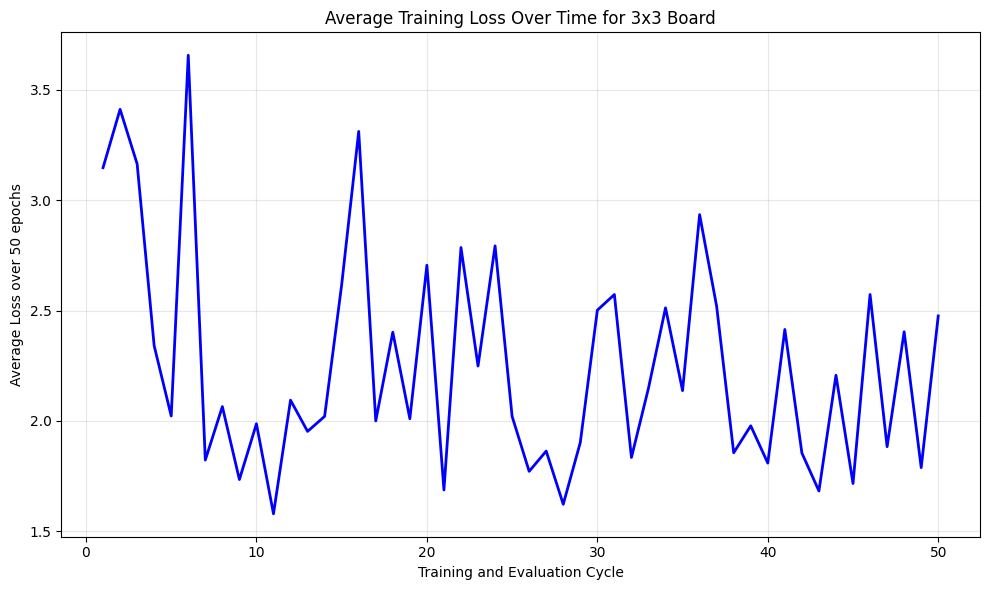

In [27]:
import matplotlib.pyplot as plt 

with open("losses_3x3.txt",  "r") as f: 
    losses = [float(line.strip()) for line in f if line.strip()]

cycles = list(range(1, len(losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(cycles, losses, 'b-', linewidth=2)
plt.xlabel('Training and Evaluation Cycle')
plt.ylabel('Average Loss over 50 epochs')
plt.title('Average Training Loss Over Time for 3x3 Board')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
    

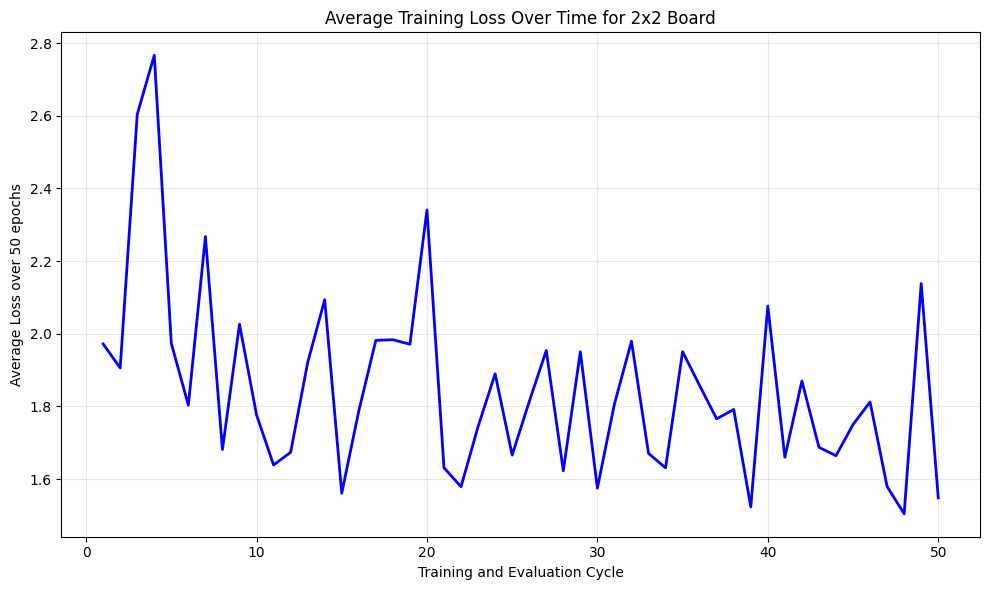

In [35]:
with open("losses_2x2.txt",  "r") as f: 
    losses = [float(line.strip()) for line in f if line.strip()]


cycles = list(range(1, len(losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(cycles, losses, 'b-', linewidth=2)
plt.xlabel('Training and Evaluation Cycle')
plt.ylabel('Average Loss over 50 epochs')
plt.title('Average Training Loss Over Time for 2x2 Board')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# API Setup - End of Document

In [ ]:
import secrets
import json
import os

def generate_api_key():
    return secrets.token_urlsafe(32)

def update_index_html_api_key(new_api_key, html_path="templates/index.html"):
    import re

    with open(html_path, "r", encoding="utf-8") as f:
        content = f.read()

    # Regex
    pattern = r'const\s+API_KEY\s*=\s*[`"\'][^`"\';]*[`"\'];?'
    replacement = f"const API_KEY = `{new_api_key}`;"
    new_content = re.sub(pattern, replacement, content)

    with open(html_path, "w", encoding="utf-8") as f:
        f.write(new_content)

def setup_api(notebook_filename='Dots_and_Boxes_Model.ipynb'): # change name to file name
    api_key = generate_api_key()

    config = {
        "api_key": api_key,
        "port": 5000,
        "host": "0.0.0.0",
        "notebook_path": notebook_filename
    }

    config_path = 'api_config.json' # saves config
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)

    html_path = os.path.join("templates", "index.html")
    update_index_html_api_key(api_key, html_path)

    return api_key

In [ ]:
api_key = setup_api(notebook_filename='Dots_and_Boxes_Model.ipynb')
print(f"Your API Key: {api_key}")
print("\nDownload these files:\n1.This Notebook\n2.notebook_to_api.py\n3.requirements.txt\n4.templates/index.html")
print("\nOpen command prompt & run:\npip install -r requirements.txt\npython notebook_to_api.py")
print("\nOpen browser on http://localhost:5000")

Your API Key: nv3riGf1FlYrutE7o6-H9U5VoQ8hk7nWPPXFfTu4Xq4

Download these files:
1.This Notebook
2.notebook_to_api.py
3.requirements.txt
4.templates/index.html

Open command prompt & run:
pip install -r requirements.txt
python notebook_to_api.py

Open browser on http://localhost:5000
